In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi' : 100,
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'font.size' : 12
})

import numpy as np

import sys
sys.path.append('/Users/kylevangorkom/Science/github/stp_context_pr_sims/code')
import fdpr2

import hda
from poppy import zernike
import hcipy as hp

from importlib import reload

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


ModuleNotFoundError: No module named 'hda'

# Generate some PSFs

In [473]:
# CONTEXT camera (Sony IMX455 CMOS: 3.76µm pixels, rolling shutter, 16bit ADC, ~60mpix)
# some info here: https://www.baader-planetarium.com/en/blog/comparing-the-imx455-industry-grade-and-kai-11002-35mm-format-monochrome-sensors/

# more specs here: https://www.qhyccd.com/qhyccd-qhy600pro-imx455-cmos/

# throughput calculations
refl_BAL = 0.9 # bare aluminum primary
refl_ALSiO2 = 0.9 # Al + SiO2 for M2-M4
BS = 0.5 # for getting two defocused fields
material_throughput = refl_BAL * (refl_ALSiO2**3) * BS

model_dict = {
    'D' : 6.46, # primary (m)
    'Ds' : 1.3, # secondary (m) (estimate)
    'spider_width' : 0.15, # (m) (complete guess)
    'wavelen' : 650e-9, # (m) (who knows)
    'fnum' : 15., # f number at context cam
    'pix_size' : 3.76e-6, # pixel size for context cam
    'rn' : 1,#3.7, # read noise (3.7 e- at low gain; 1 e- at high gain)
    'qe' : 0.7, # value at 600 nm
    'dc' : 0.0022, #e-/pix/s at -20 C (0.014 at 0C)
    'pupil_sampling' : 128, 
    'focal_extent' : 50, #20, # lambda/D
    'defocus_waves' : [-1, 1],#[-0.5, 0.5],
    'throughput' : material_throughput,
    'filter_bw' : 10./650.,
    'num_wavelen' : 1,
    'lambda_rms' : 50/650., # waves RMS for desired Strehl of 0.4
}

focal_prop, defocus_props, pupil, focal_grid, pupil_nospiders = hda.get_forward_model(model_dict)
modes = zernike.arbitrary_basis(pupil.shaped, nterms=40, outside=0)
ptt = hp.mode_basis.make_zernike_basis(3, model_dict['D'], pupil.grid)

collecting_area = np.sum(np.asarray(pupil)) / len(pupil) * 6.5*6.5 #m^2
model_dict.update({
    'collecting_area' : collecting_area,
})


# filter for PSFs
han = np.hanning(focal_grid.dims[0])
han2d = np.outer(han, han)

# define more-finely sampled pupil grid for jitter convolution (sub-pixel effects)
npix = focal_grid.shape[0]
oversample = 2
jitter_pix_extent = npix / 2.0 * model_dict['pix_size']
jitter_pix_range = ((-jitter_pix_extent, jitter_pix_extent),(-jitter_pix_extent, jitter_pix_extent))
jitter_pix_num = (npix*oversample + 1, npix*oversample + 1)

In [474]:
def make_obstructed_circular_aperture(pupil_diameter, central_obscuration_ratio, num_spiders=0, spider_widths=[0.01,]):
        '''Make a simple circular aperture with central obscuration and support structure.

        Parameters
        ----------
        pupil_diameter : scalar
                The diameter of the circular aperture.
        central_obscuration_ratio : scalar
                The ratio of the diameter of the central obscuration compared to the pupil diameter.
        num_spiders : int
                The number of spiders holding up the central obscuration.
        spider_width : scalar
                The full width of the spiders.

        Returns
        -------
        Field generator
                The circularly obstructed aperture.
        '''
        central_obscuration_diameter = pupil_diameter * central_obscuration_ratio

        def func(grid):
                pupil_outer = hp.circular_aperture(pupil_diameter)(grid)
                pupil_inner = hp.circular_aperture(central_obscuration_diameter)(grid)
                spiders = 1

                spider_angles = np.linspace(0, 2*np.pi, num_spiders, endpoint=False)

                for i, angle in enumerate(spider_angles):
                        x = pupil_diameter * np.cos(angle)
                        y = pupil_diameter * np.sin(angle)

                        spiders *= hp.make_spider((0, 0), (x, y), spider_widths[i])(grid)

                return (pupil_outer - pupil_inner) * spiders
        return func

In [475]:
wavefront = hp.Wavefront(pupil, wavelength=model_dict['wavelen'])
ab = hda.SurfaceAberrationRMS(pupil.grid, 0.5*model_dict['lambda_rms']*model_dict['wavelen'],
                          model_dict['D'], aperture=pupil, exponent=-4, remove_modes=ptt)
ab_wf = ab(wavefront)
phase_true = ab.opd * 2*np.pi / model_dict['wavelen'] # calculate here to avoid wrapping
mag = 10
exp = 5
nimage = 10

psfs, allfocal = hda.get_defocused_images_broadband(ab_wf, focal_prop, defocus_props, model_dict,
                            mag=mag, integration_time=exp, include_noise=True, subtract_dark=True, nimages=nimage,
                            sigma=None, jitter_kernels=None)


In [476]:
from magpyx.imutils import fft2_shiftnorm
from skimage.filters import threshold_otsu

pupil_fft = np.abs(ifft2_shiftnorm(allfocal[0].electric_field.shaped))
thresh = threshold_otsu(pupil_fft)
fitmask = pupil_fft > thresh

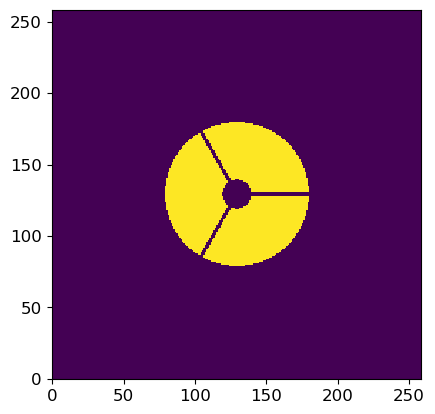

In [477]:
plt.imshow(fitmask)

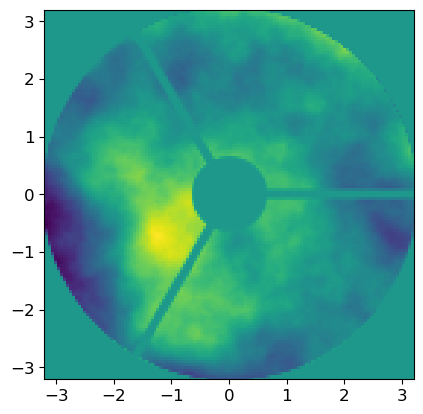

In [478]:
hp.imshow_field(phase_true)

# Run the PR

choose some fitting parameters

In [576]:
# PV to RMS and sign convention change
Ediv = fdpr2.get_defocus_probes(fitmask, -0.25*np.asarray(model_dict['defocus_waves']))

tol = 1e-6
reg = 0
wreg = 10

# square-ify the PSFs
psfs_sq = np.asarray([p.shaped for p in psfs])

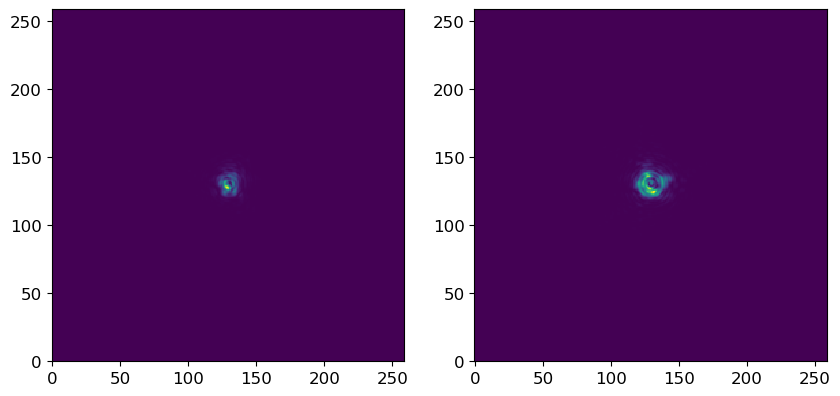

In [577]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(psfs_sq[0])
axes[1].imshow(psfs_sq[1])

pixel-by-pixel fit (phase and amplitude)

In [579]:
prdict = fdpr2.run_phase_retrieval(psfs_sq, fitmask, tol, reg, wreg, Ediv, modes=None, fit_amp=True)

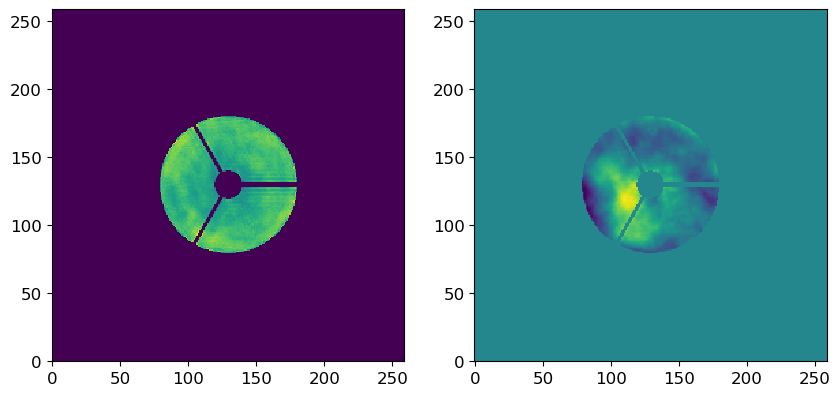

In [580]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(prdict['amp_est'])
axes[1].imshow(prdict['phase_est'])

modal fit (phase-only)

In [582]:
modes = zernike.arbitrary_basis(fitmask, nterms=100, outside=0)

In [583]:
prdict = fdpr2.run_phase_retrieval(psfs_sq, fitmask, tol, reg, wreg, Ediv, modes=modes, fit_amp=False)

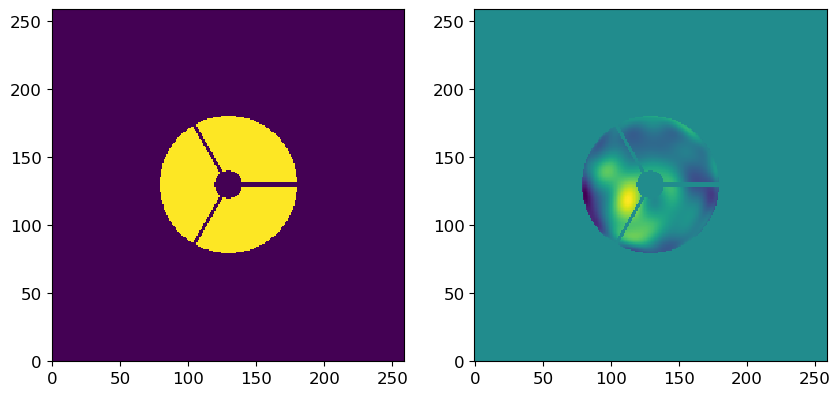

In [585]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(fitmask)
axes[1].imshow(prdict['phase_est'])